В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.
Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

In [134]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import probplot

In [2]:
train_data = pd.read_csv(
    "data/assignment_2_train.csv"
)
print("data.shape = {} rows, {} cols".format(*train_data.shape))
train_data.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test_data = pd.read_csv(
    "data/assignment_2_test.csv"
)
print("data.shape = {} rows, {} cols".format(*test_data.shape))
test_data.head(n=2)

data.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


__Задание 1:__ отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [5]:
numerical_features = train_data.select_dtypes(include=[np.number])

In [6]:
numerical_features.shape

(180000, 380)

In [7]:
target = numerical_features['isFraud']

In [8]:
numerical_features = numerical_features.drop(['TransactionID', 'isFraud'], axis=1)

In [74]:
X_train, X_test = train_test_split(numerical_features, train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [75]:
X_train.shape, X_valid.shape, X_test.shape

((108000, 378), (36000, 378), (36000, 378))

In [76]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [77]:
xgb_train = xgb.DMatrix(data=X_train, label=y_train)
xgb_valid = xgb.DMatrix(data=X_valid, label=y_valid)
xgb_test = xgb.DMatrix(data=X_test, label=y_test)

In [78]:
model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(xgb_train, "train"), (xgb_valid, "valid"), (xgb_test, "test")],
    verbose_eval=10,
    maximize=True,
)

[01:20:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65507	valid-auc:0.64410	test-auc:0.63977
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[10]	train-auc:0.75290	valid-auc:0.73784	test-auc:0.73806
[20]	train-auc:0.82171	valid-auc:0.82093	test-auc:0.81478
[30]	train-auc:0.85931	valid-auc:0.85505	test-auc:0.84872
[40]	train-auc:0.86806	valid-auc:0.86384	test-auc:0.86224
[50]	train-auc:0.88223	valid-auc:0.87520	test-auc:0.87255
[60]	train-auc:0.88862	valid-auc:0.87939	test-auc:0.87758
[70]	train-auc:0.89207	valid-auc:0.88193	test-auc:0.88076
[80]	t

__Задание 10:__ построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [72]:
def roc_plot(model, y_train, y_train_pred, y_valid, y_valid_pred, y_test, y_test_pred):  
    

    plt.figure(figsize=(14, 7))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')   
    
    fpr, tpr, _ = roc_curve(y_train, y_train_pred)
    plt.plot(fpr, tpr, label=f'train (area = {auc(fpr, tpr):.5})')
    
    fpr, tpr, _ = roc_curve(y_valid, y_valid_pred)
    plt.plot(fpr, tpr, label=f'valid (area = {auc(fpr, tpr):.5})')
    
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    plt.plot(fpr, tpr, label=f'test (area = {auc(fpr, tpr):.5})')
    
    plt.legend(loc="lower right")
    
    plt.show()
    

In [79]:
y_train_pred = model.predict(xgb_train)
y_valid_pred = model.predict(xgb_valid)
y_test_pred = model.predict(xgb_test)

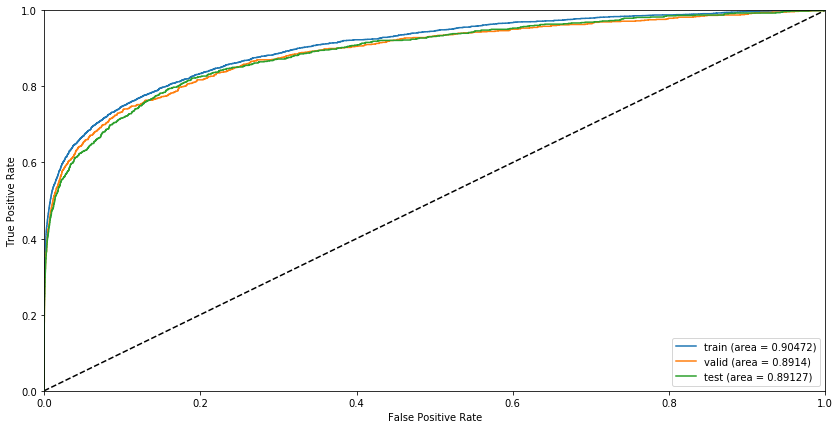

In [80]:
roc_plot(model, 
         y_train.values, y_train_pred, 
         y_valid.values, y_valid_pred, 
         y_test.values, y_test_pred)

Качество работы алгоритма на тренировочной и тестовой выборках очень близко, переобучения нет

__Задание 2:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [40]:
categorical_features = train_data.select_dtypes(include=[np.object])

In [41]:
categorical_features.columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [42]:
categorical_features.M9.value_counts()

T    26970
F     4682
Name: M9, dtype: int64

In [43]:
cat_features_dummies = pd.get_dummies(categorical_features[['ProductCD','card4','card6','M4']], 
               prefix=['ProductCD','card4','card6','M4'])

In [44]:
cat_features_dummies.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [45]:
for feature in ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    cat_features_dummies[feature + '_01'] = np.where(categorical_features[feature] =='T',1,0)

In [46]:
cat_features_dummies.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,M4_M1,M4_M2,M1_01,M2_01,M3_01,M5_01,M6_01,M7_01,M8_01,M9_01
0,0,0,0,0,1,0,1,0,0,0,...,0,1,1,1,1,0,1,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [47]:
df2 = pd.DataFrame(categorical_features.P_emaildomain.value_counts()*100/categorical_features.shape[0])

In [48]:
df2 = df2.reset_index()

In [49]:
df2 = df2.rename(columns ={'index': 'P_emaildomain', 'P_emaildomain': 'P_emaildomain_freq'})

In [50]:
df2.head(2)

,P_emaildomain,P_emaildomain_freq
0,gmail.com,37.332222
1,yahoo.com,16.106667


In [51]:
cat_features_dummies['P_emaildomain_freq'] = categorical_features.merge(df2, on='P_emaildomain', how='left')['P_emaildomain_freq']

In [52]:
cat_features_dummies.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,M4_M2,M1_01,M2_01,M3_01,M5_01,M6_01,M7_01,M8_01,M9_01,P_emaildomain_freq
0,0,0,0,0,1,0,1,0,0,0,...,1,1,1,1,0,1,0,0,0,NaN
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,37.332222


In [53]:
df2 = pd.DataFrame(categorical_features.R_emaildomain.value_counts()*100/categorical_features.shape[0])
df2 = df2.reset_index()
df2 = df2.rename(columns ={'index': 'R_emaildomain', 'R_emaildomain': 'R_emaildomain_freq'})
df2.head(2)

,R_emaildomain,R_emaildomain_freq
0,gmail.com,13.691111
1,hotmail.com,5.627222


In [54]:
cat_features_dummies['R_emaildomain_freq'] = categorical_features.merge(df2, on='R_emaildomain', how='left')['R_emaildomain_freq']

In [55]:
cat_features_dummies['P_emaildomain_freq'] = np.where(np.isnan(cat_features_dummies['P_emaildomain_freq']),-1,cat_features_dummies['P_emaildomain_freq'])

In [56]:
cat_features_dummies['R_emaildomain_freq'] = np.where(np.isnan(cat_features_dummies['R_emaildomain_freq']),-1,cat_features_dummies['R_emaildomain_freq'])

In [57]:
cat_features_dummies.head(2)

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,M1_01,M2_01,M3_01,M5_01,M6_01,M7_01,M8_01,M9_01,P_emaildomain_freq,R_emaildomain_freq
0,0,0,0,0,1,0,1,0,0,0,...,1,1,1,0,1,0,0,0,-1.000000,-1.0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,37.332222,-1.0


In [58]:
X_train, X_test = train_test_split(pd.concat([numerical_features, cat_features_dummies], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [59]:
X_train.shape, X_valid.shape, X_test.shape

((108000, 404), (36000, 404), (36000, 404))

In [60]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [61]:
xgb_train = xgb.DMatrix(data=X_train, label=y_train)
xgb_valid = xgb.DMatrix(data=X_valid, label=y_valid)
xgb_test = xgb.DMatrix(data=X_test, label=y_test)

In [62]:
model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(xgb_train, "train"), (xgb_valid, "valid"), (xgb_test, "test")],
    verbose_eval=10,
    maximize=True,
)

[01:14:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65507	valid-auc:0.64410	test-auc:0.63977
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[10]	train-auc:0.75290	valid-auc:0.73783	test-auc:0.73807
[20]	train-auc:0.82177	valid-auc:0.82090	test-auc:0.81480
[30]	train-auc:0.86045	valid-auc:0.85661	test-auc:0.85004
[40]	train-auc:0.87932	valid-auc:0.87027	test-auc:0.86814
[50]	train-auc:0.88816	valid-auc:0.87946	test-auc:0.87593
[60]	train-auc:0.89583	valid-auc:0.88521	test-auc:0.88177
[70]	train-auc:0.90049	valid-auc:0.88797	test-auc:0.88703
[80]	t

Сравним с Заданием 1:  train-auc:0.91481	valid-auc:0.89896	test-auc:0.90040

Значения метрик качества не изменились

In [64]:
y_train_pred = model.predict(xgb_train)
y_valid_pred = model.predict(xgb_valid)
y_test_pred = model.predict(xgb_test)

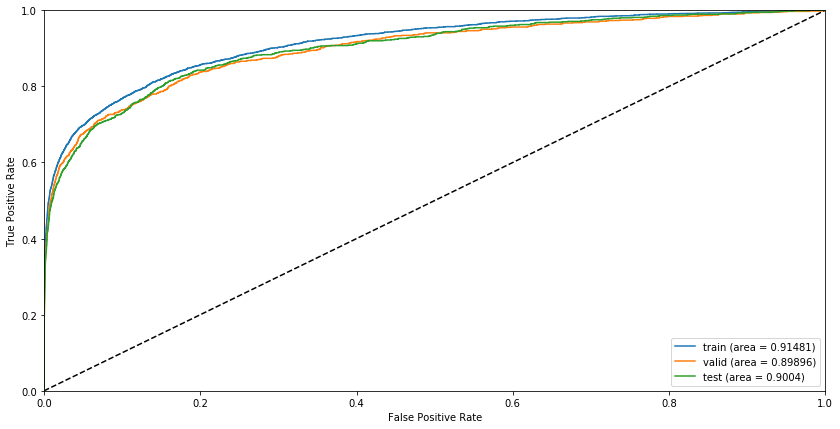

In [73]:
roc_plot(model, 
         y_train.values, y_train_pred, 
         y_valid.values, y_valid_pred, 
         y_test.values, y_test_pred)

Качество работы алгоритма на тренировочной и тестовой выборках очень близко, переобучения нет

__Задание 4:__ для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [81]:
X_train, X_test = train_test_split(numerical_features, train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [82]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [117]:
train_lgb = lgb.Dataset(data=X_train, label=y_train)
valid_lgb = lgb.Dataset(data=X_valid, label=y_valid)
test_lgb = lgb.Dataset(data=X_test, label=y_test)

model_lgb = lgb.train(
    params=params,
    train_set=train_lgb,
    num_boost_round=10000,
    valid_sets=[train_lgb, valid_lgb, test_lgb],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

[LightGBM] [Info] Number of positive: 3136, number of negative: 104864
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31007
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029037 -> initscore=-3.509716
[LightGBM] [Info] Start training from score -3.509716
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.894305	valid_1's auc: 0.881002	valid_2's auc: 0.879208
[200]	training's auc: 0.914252	valid_1's auc: 0.894078	valid_2's auc: 0.895079
[300]	training's auc: 0.929414	valid_1's auc: 0.903446	valid_2's auc: 0.904488
[400]	training's auc: 0.943065	valid_1's auc: 0.911812	valid_2's auc: 0.910669
[500]	training's auc: 0.951791	valid_1's auc: 0.915911	vali

Сравним с Заданием 1:  train-auc:0.91481	valid-auc:0.89896	test-auc:0.90040

Итераций потребовалось существенно больше, чем для XGB, зато результат на тестовой выборке улучшился на 0.04

In [83]:
X_train, X_test = train_test_split(numerical_features, train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [84]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [85]:
train_lgb = lgb.Dataset(data=X_train, label=y_train)
valid_lgb = lgb.Dataset(data=X_valid, label=y_valid)
test_lgb = lgb.Dataset(data=X_test, label=y_test)

model_lgb = lgb.train(
    params=params,
    train_set=train_lgb,
    num_boost_round=10000,
    valid_sets=[train_lgb, valid_lgb, test_lgb],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

C:\Users\Zharo\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 3136, number of negative: 104864
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31007
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 376
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029037 -> initscore=-3.509716
[LightGBM] [Info] Start training from score -3.509716
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.894305	valid_1's auc: 0.881002	valid_2's auc: 0.879208
[200]	training's auc: 0.914337	valid_1's auc: 0.895579	valid_2's auc: 0.895112
[300]	training's auc: 0.927966	valid_1's auc: 0.903622	valid_2's auc: 0.905154
[400]	training's auc: 0.940318	valid_1's auc: 0.910883	valid_2's auc: 0.911798
[500]	training's auc: 0.948892

Goss улучшает результат, но и увеличивает количество итераций

In [89]:
y_train_pred = model_lgb.predict(X_train)
y_valid_pred = model_lgb.predict(X_valid)
y_test_pred = model_lgb.predict(X_test)

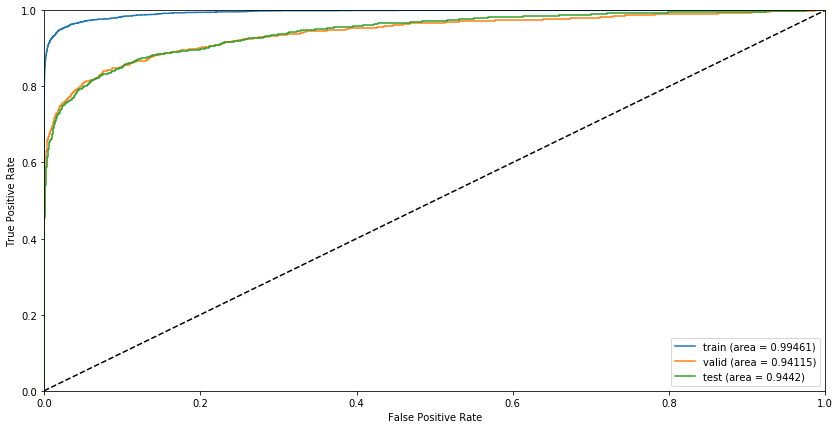

In [90]:
roc_plot(model, 
         y_train.values, y_train_pred, 
         y_valid.values, y_valid_pred, 
         y_test.values, y_test_pred)

Качество на тренировочной выборке существенно лучше, чем на валидационной и тестовой. Можно говорить о переобучении модели

__Задание 5:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [91]:
X_train, X_test = train_test_split(pd.concat([numerical_features, cat_features_dummies], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [92]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [114]:
train_lgb = lgb.Dataset(data=X_train, label=y_train)
valid_lgb = lgb.Dataset(data=X_valid, label=y_valid)
test_lgb = lgb.Dataset(data=X_test, label=y_test)

model_lgb = lgb.train(
    params=params,
    train_set=train_lgb,
    num_boost_round=10000,
    valid_sets=[train_lgb, valid_lgb, test_lgb],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3136, number of negative: 104864
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31161
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 400
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029037 -> initscore=-3.509716
[LightGBM] [Info] Start training from score -3.509716
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.900472	valid_1's auc: 0.884932	valid_2's auc: 0.883437
[200]	training's auc: 0.919184	valid_1's auc: 0.900495	v

Без категориальных: training's auc: 0.997834	valid_1's auc: 0.938648	valid_2's auc: 0.94273

Улучшили в 3 знаке после запятой

Теперь то же самое с "boosting_type" = "goss"

In [93]:
X_train, X_test = train_test_split(pd.concat([numerical_features, cat_features_dummies], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [94]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [95]:
train_lgb = lgb.Dataset(data=X_train, label=y_train)
valid_lgb = lgb.Dataset(data=X_valid, label=y_valid)
test_lgb = lgb.Dataset(data=X_test, label=y_test)

model_lgb = lgb.train(
    params=params,
    train_set=train_lgb,
    num_boost_round=10000,
    valid_sets=[train_lgb, valid_lgb, test_lgb],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3136, number of negative: 104864
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31161
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 400
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029037 -> initscore=-3.509716
[LightGBM] [Info] Start training from score -3.509716
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.900472	valid_1's auc: 0.884932	valid_2's auc: 0.883437
[200]	training's auc: 0.920

Качество еще улучшилось на 0.06

In [96]:
y_train_pred = model_lgb.predict(X_train)
y_valid_pred = model_lgb.predict(X_valid)
y_test_pred = model_lgb.predict(X_test)

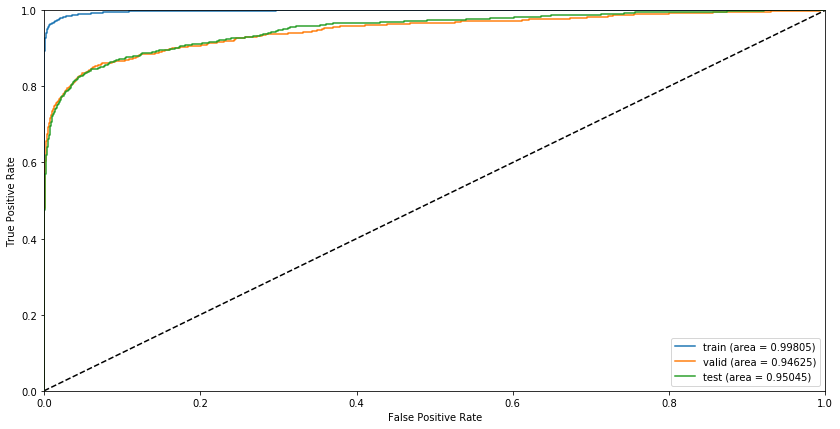

In [97]:
roc_plot(model, 
         y_train.values, y_train_pred, 
         y_valid.values, y_valid_pred, 
         y_test.values, y_test_pred)

Качество на тренировочной выборке существенно лучше, чем на валидационной и тестовой. Можно говорить о переобучении модели

__Задание 6:__ обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [98]:
X_train, X_test = train_test_split(pd.concat([numerical_features, categorical_features], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [99]:
for c in categorical_features.columns.tolist():
    X_train[c] = X_train[c].astype('category')
    X_valid[c] = X_valid[c].astype('category')
    X_test[c] = X_test[c].astype('category')

In [100]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

In [101]:
categorical_features.columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [102]:
train_lgb = lgb.Dataset(data=X_train, label=y_train)
valid_lgb = lgb.Dataset(data=X_valid, label=y_valid)
test_lgb = lgb.Dataset(data=X_test, label=y_test)

model_lgb = lgb.train(
    params=params,
    train_set=train_lgb,
    num_boost_round=10000,
    valid_sets=[train_lgb, valid_lgb, test_lgb],
    categorical_feature=['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9'],
    early_stopping_rounds=50,
    verbose_eval=100
)

C:\Users\Zharo\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4', 'card6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 3136, number of negative: 104864
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31170
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] Using GOSS


C:\Users\Zharo\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\Zharo\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029037 -> initscore=-3.509716
[LightGBM] [Info] Start training from score -3.509716
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.903347	valid_1's auc: 0.887505	valid_2's auc: 0.886232
[200]	training's auc: 0.924918	valid_1's auc: 0.904163	valid_2's auc: 0.901097
[300]	training's auc: 0.93796	valid_1's auc: 0.913382	valid_2's auc: 0.910885
[400]	training's auc: 0.948745	valid_1's auc: 0.919469	valid_2's auc: 0.918173
[500]	training's auc: 0.956723	valid_1's auc: 0.924276	valid_2's auc: 0.92341
[600]	training's auc: 0.96274	valid_1's auc: 0.927554	valid_2's auc: 0.927405
[700]	training's auc: 0.967125	valid_1's auc: 0.929945	valid_2's auc: 0.929935
[800]	training's auc: 0.971194	valid_1's auc: 0.931774	valid_2's auc: 0.93195
[900]	training's auc: 0.974799	valid_1's auc: 0.933461	valid_2's auc: 0.933931
[1000]	training's auc: 0.977917	valid_1's auc: 0.935003	valid_2's auc: 0.935716
[1100]	training's 

Результат получился хуже, чем при ручной обработке признаков

In [103]:
y_train_pred = model_lgb.predict(X_train)
y_valid_pred = model_lgb.predict(X_valid)
y_test_pred = model_lgb.predict(X_test)

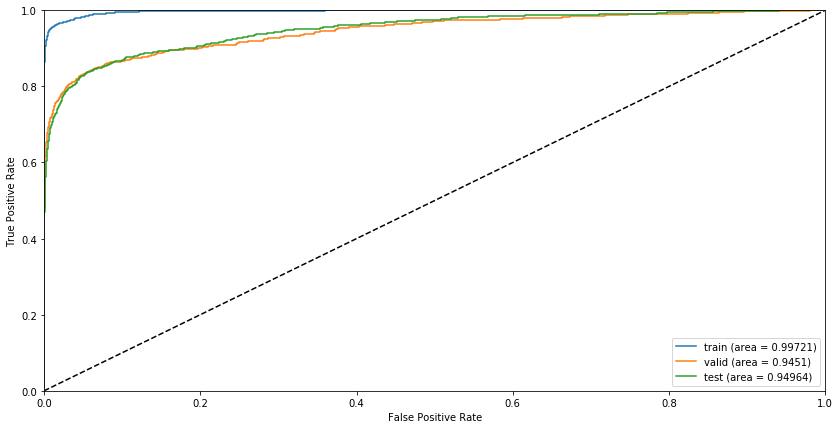

In [104]:
roc_plot(model, 
         y_train.values, y_train_pred, 
         y_valid.values, y_valid_pred, 
         y_test.values, y_test_pred)

Качество на тренировочной выборке существенно лучше, чем на валидационной и тестовой. Можно говорить о переобучении модели

__Задание 7:__ для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [105]:
X_train, X_test = train_test_split(numerical_features, train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [106]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 8,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [107]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

0:	test: 0.6101680	test1: 0.5919166	test2: 0.5981872	best: 0.5981872 (0)	total: 195ms	remaining: 32m 33s
100:	test: 0.8717335	test1: 0.8644623	test2: 0.8643401	best: 0.8643401 (100)	total: 13s	remaining: 21m 16s
200:	test: 0.8869548	test1: 0.8753346	test2: 0.8774744	best: 0.8774744 (200)	total: 27.2s	remaining: 22m 8s
300:	test: 0.8937602	test1: 0.8805351	test2: 0.8835462	best: 0.8835462 (300)	total: 41.4s	remaining: 22m 14s
400:	test: 0.8990534	test1: 0.8846963	test2: 0.8879394	best: 0.8879394 (400)	total: 54.8s	remaining: 21m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8890300222
bestIteration = 442

Shrink model to first 443 iterations.


Результат до только числовым признакам хуже, чем у других алгоритмов

In [116]:
y_train_pred = model_cb.predict_proba(X_train)
y_valid_pred = model_cb.predict_proba(X_valid)
y_test_pred = model_cb.predict_proba(X_test)

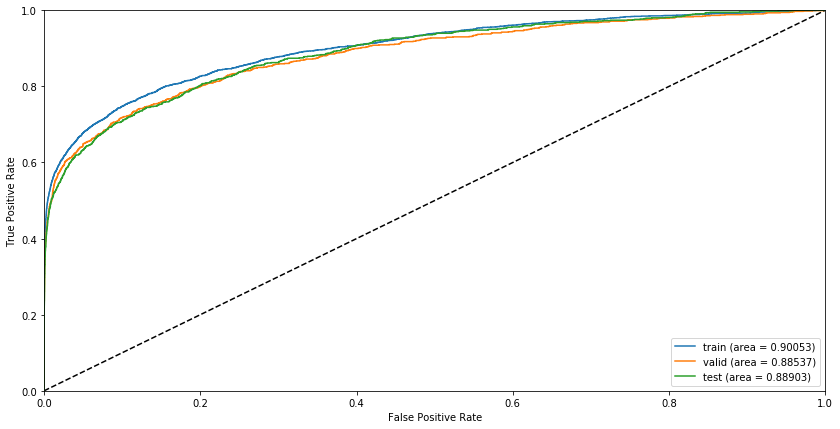

In [117]:
roc_plot(model, 
         y_train.values, y_train_pred[:, 1], 
         y_valid.values, y_valid_pred[:, 1], 
         y_test.values, y_test_pred[:, 1])

Качество работы алгоритма на тренировочной и тестовой выборках очень близко, переобучения нет

__Задание 8:__ обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [118]:
X_train, X_test = train_test_split(pd.concat([numerical_features, cat_features_dummies], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [119]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 8,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [120]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

0:	test: 0.6497346	test1: 0.6365822	test2: 0.6337465	best: 0.6337465 (0)	total: 140ms	remaining: 23m 22s
100:	test: 0.8748592	test1: 0.8671429	test2: 0.8675394	best: 0.8678471 (95)	total: 13s	remaining: 21m 9s
200:	test: 0.8925495	test1: 0.8804757	test2: 0.8820167	best: 0.8820167 (200)	total: 27.8s	remaining: 22m 33s
300:	test: 0.9023921	test1: 0.8882195	test2: 0.8902873	best: 0.8902920 (299)	total: 42.1s	remaining: 22m 36s
400:	test: 0.9076542	test1: 0.8923653	test2: 0.8949188	best: 0.8949188 (400)	total: 56.2s	remaining: 22m 24s
500:	test: 0.9111009	test1: 0.8948780	test2: 0.8975581	best: 0.8975829 (472)	total: 1m 9s	remaining: 22m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8975829112
bestIteration = 472

Shrink model to first 473 iterations.


Значение метрики улучшилось на 0.0085

In [121]:
y_train_pred = model_cb.predict_proba(X_train)
y_valid_pred = model_cb.predict_proba(X_valid)
y_test_pred = model_cb.predict_proba(X_test)

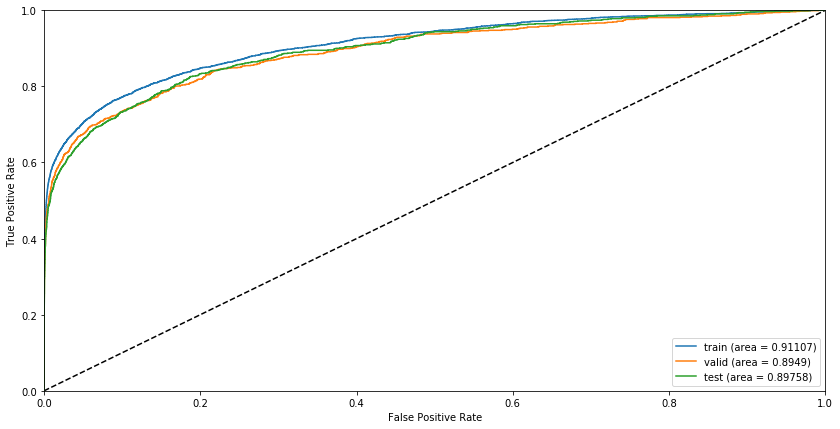

In [122]:
roc_plot(model, 
         y_train.values, y_train_pred[:, 1], 
         y_valid.values, y_valid_pred[:, 1], 
         y_test.values, y_test_pred[:, 1])

Качество работы алгоритма на тренировочной и тестовой выборках очень близко, переобучения нет

__Задание 9:__ обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [123]:
X_train, X_test = train_test_split(pd.concat([numerical_features, categorical_features], axis=1), train_size=0.8, random_state=42)
X_train, X_valid = train_test_split(X_train, train_size=0.75, random_state=42)
y_train, y_test = train_test_split(target, train_size=0.8, random_state=42)
y_train, y_valid = train_test_split(y_train, train_size=0.75, random_state=42)

In [124]:
for c in categorical_features.columns.tolist():
    X_train[c] = X_train[c].astype('str')
    X_valid[c] = X_valid[c].astype('str')
    X_test[c] = X_test[c].astype('str')

In [125]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 8,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [126]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(X_train, 
             y_train, 
             eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)],
             cat_features=['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9'])

0:	test: 0.6272515	test1: 0.6190818	test2: 0.6138460	best: 0.6138460 (0)	total: 827ms	remaining: 2h 17m 54s
100:	test: 0.8726796	test1: 0.8625622	test2: 0.8657560	best: 0.8657560 (100)	total: 1m 17s	remaining: 2h 6m 14s
200:	test: 0.8939236	test1: 0.8818296	test2: 0.8831198	best: 0.8831198 (200)	total: 2m 38s	remaining: 2h 8m 47s
300:	test: 0.9023283	test1: 0.8891881	test2: 0.8894959	best: 0.8895022 (299)	total: 3m 59s	remaining: 2h 8m 51s
400:	test: 0.9085262	test1: 0.8940824	test2: 0.8944481	best: 0.8944494 (399)	total: 5m 32s	remaining: 2h 12m 48s
500:	test: 0.9120837	test1: 0.8972792	test2: 0.8972420	best: 0.8972451 (483)	total: 6m 57s	remaining: 2h 11m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8972451276
bestIteration = 483

Shrink model to first 484 iterations.


Метрика качества немного ухудшилась по сранению с вручную обработанными категориальными признаками

In [127]:
y_train_pred = model_cb.predict_proba(X_train)
y_valid_pred = model_cb.predict_proba(X_valid)
y_test_pred = model_cb.predict_proba(X_test)

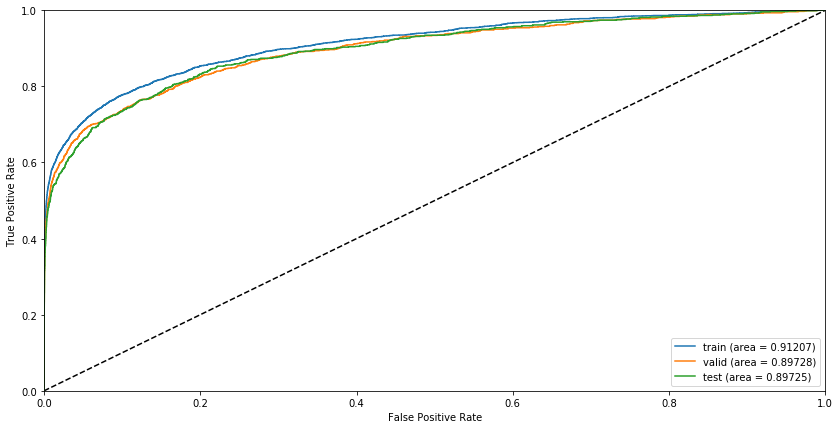

In [128]:
roc_plot(model, 
         y_train.values, y_train_pred[:, 1], 
         y_valid.values, y_valid_pred[:, 1], 
         y_test.values, y_test_pred[:, 1])

Качество работы алгоритма на тренировочной и тестовой выборках очень близко, переобучения нет

Таким образом, хотя LightGBM показывает бОльшие значения метрики качества, но качество на тренировочной выборке получается существенно лучше, чем на валидационной и тестовой, что дает основания говорить о переобучении модели.

Наиболее близкие значения метрик на всех трех выборках показывает XGBoost. К тому же значения метрик качества у этой модели получились выше, чем у CatBoost.

__Задание на повторение:__

__Задание 1:__ Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

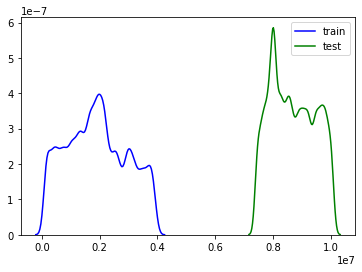

In [131]:
sns.kdeplot(train_data['TransactionDT'], color="blue", label="train")
sns.kdeplot(test_data['TransactionDT'], color="green", label="test")

Данные на тренировочной и тестовой выборках представлены за разные периоды времени, причем на тестовой выборке период короче.

__Задание 2:__ построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

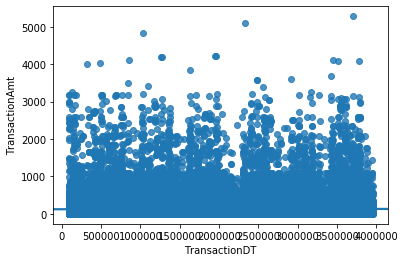

In [17]:
sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=train_data[train_data['isFraud']==0],
        scatter=True,
        fit_reg=True
    )

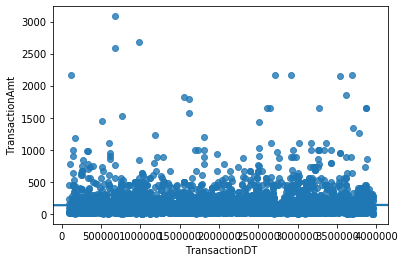

In [18]:
sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=train_data[train_data['isFraud']==1],
        scatter=True,
        fit_reg=True
    )

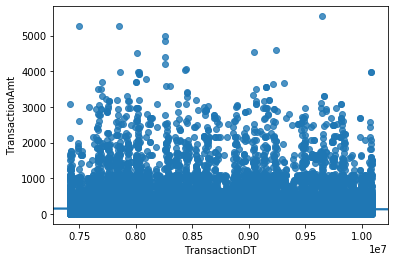

In [13]:
sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=test_data,
        scatter=True,
        fit_reg=True
    )

Распределение сумм транзаций равномерно во времени. При этом для значений целевой переменной равных 0 присутствуют периодические увеличения сумм (равномерно повторяющиеся), похожие "всплески" есть и на тестовой выборке, но их количество меньше (так как временной период меньше). Однако для значений целевой переменной равных 1 картина более сглаженная.

__Задание 3:__ построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

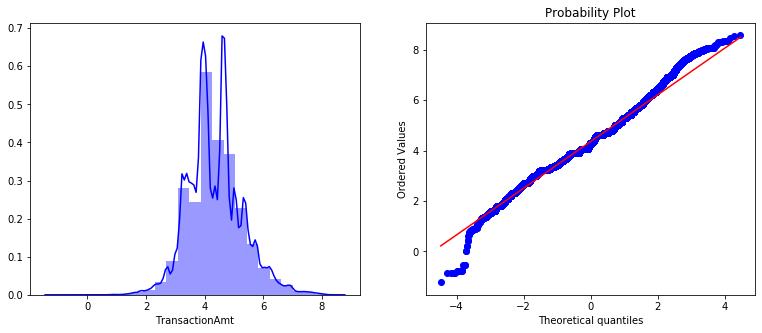

In [136]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(np.log(train_data['TransactionAmt']), bins=25, color="blue")
plt.subplot(122)
probplot(np.log(train_data['TransactionAmt']), plot=plt)
plt.show()

Данное распределение нельзя считать близким к нормальному

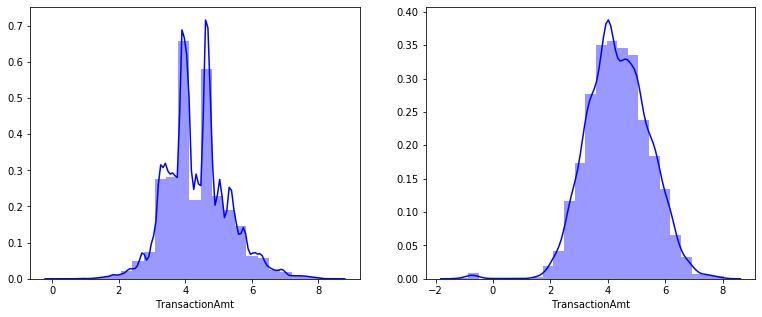

In [138]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(np.log(train_data[train_data['isFraud']==0]['TransactionAmt']), bins=25, color="blue")
plt.subplot(122)
sns.distplot(np.log(train_data[train_data['isFraud']==1]['TransactionAmt']), bins=25, color="blue")
plt.show()

Распределение сумм транзаций для разных значений целевой переменной не совпадают

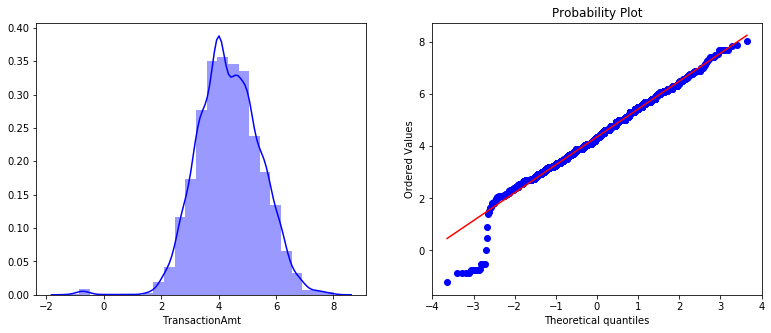

In [139]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(np.log(train_data[train_data['isFraud']==1]['TransactionAmt']), bins=25, color="blue")
plt.subplot(122)
probplot(np.log(train_data[train_data['isFraud']==1]['TransactionAmt']), plot=plt)
plt.show()

Если бы не значения TransactionAmt меньшие 1, то расределение TransactionAmt для целевой переменной равной 1 можно было бы считать логнормальным

__Задание 4:__ построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

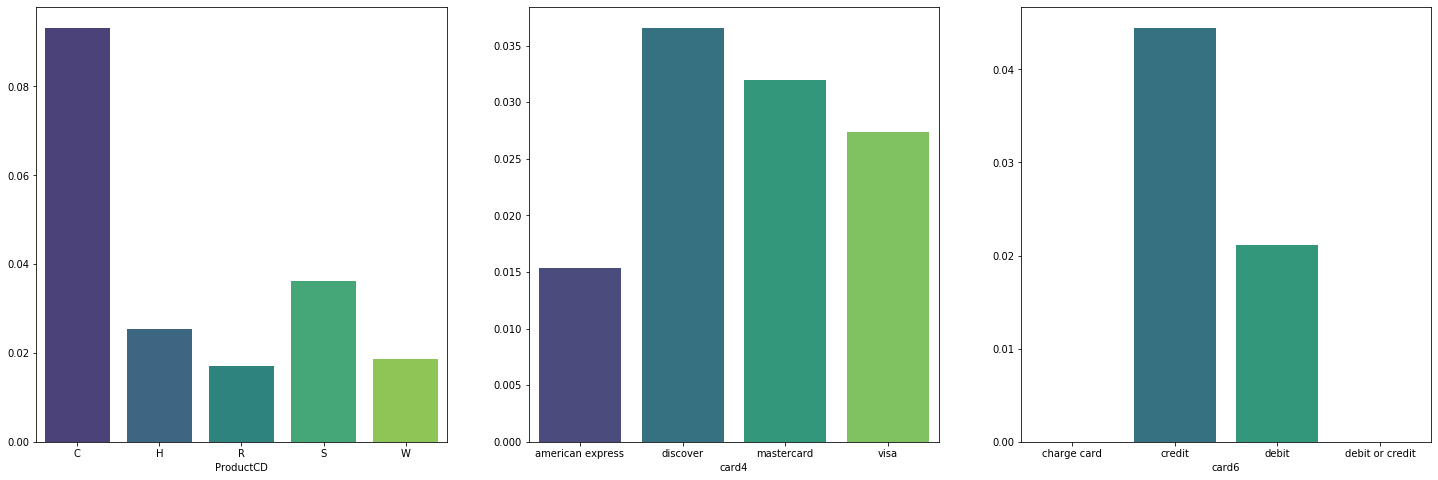

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

for num, feature in enumerate(['ProductCD', 'card4', 'card6']):
    statistics = train_data.groupby([feature])["isFraud"].mean()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%3]
    )

Зависимость целевой переменной от данных признаков довольно существенна, поэтом можно предположить, что данные признаки будут в числе важных признаков